## Vision UFormer (Defunct)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [ ]:
def transformer_encoder(inputs, output_size):
    # Layer Normalization
    norm1 = layers.LayerNormalization()(inputs)
    
    # Multi-Headed Self-Attention
    attention = layers.MultiHeadAttention(num_heads=8, key_dim=64)(norm1, norm1)
    attention = layers.Add()([inputs, attention])
    
    # Layer Normalization
    norm2 = layers.LayerNormalization()(attention)
    
    # MLP (Multi-Layer Perceptron)
    mlp = layers.Dense(output_size, activation='relu')(norm2)
    mlp = layers.Dense(inputs.shape[-1])(mlp)
    
    # Residual Connection
    encoder_output = layers.Add()([attention, mlp])
    
    return encoder_output

In [ ]:
def transformer_decoder(inputs):
    # Convolutional Layer
    conv1 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='linear')(inputs)
    
    # Weight Normalization
    wnorm = layers.experimental.preprocessing.WeightNormalization()(conv1)
    
    # Group Normalization
    gnorm = layers.LayerNormalization()(wnorm)
    
    # GELU (Gaussian Error Linear Unit)
    gelu = layers.Activation('gelu')(gnorm)
    
    # Convolutional Layer
    conv2 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='linear')(gelu)
    
    # Residual Connection
    decoder_output = layers.Add()([inputs, conv2])
    
    return decoder_output

In [ ]:
def create_vision_uformer_model(image_size, num_patches, num_classes):
    # Input
    inputs = layers.Input(shape=(image_size, image_size, 3))
    
    # Patch Extraction
    patches = layers.PatchExtractor(patch_size=(num_patches, num_patches))(inputs)
    patches = layers.Reshape((-1, num_patches * num_patches * 3))(patches)
    
    # Positional Encoding
    position_embedding = layers.Embedding(input_dim=num_patches * num_patches, output_dim=num_classes)(tf.range(num_patches * num_patches))
    position_embedding = layers.Reshape((num_patches * num_patches, num_classes))(position_embedding)
    patches_with_position = layers.Add()([patches, position_embedding])
    
    # Encoder
    encoder_output1 = transformer_encoder(patches_with_position, num_classes * 4)
    encoder_output2 = transformer_encoder(encoder_output1, num_classes * 2)
    encoder_output3 = transformer_encoder(encoder_output2, num_classes)
    
    # Decoder with Skip Layers
    decoder_output3 = transformer_decoder(encoder_output3, num_classes * 2)
    decoder_output2 = transformer_decoder(layers.Concatenate()([decoder_output3, encoder_output2]))
    decoder_output1 = transformer_decoder(layers.Concatenate()([decoder_output2, encoder_output1]))
    
    # Output
    output = layers.Dense(1, activation='sigmoid')(decoder_output1)
    
    # Create the model
    model = Model(inputs=inputs, outputs=output)
    return model

## UNet for Depth Estimation on GeoPose3k

In [1]:
import tensorflow as tf
import cv2
import numpy as np

from tensorflow import keras
from keras import layers

DATA_PATH = "C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\images_depth\\depth_dataset_updated.csv"

In [2]:
def load_npy_file(label_path):
    label = np.load(label_path)
    label = cv2.resize(label, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
    return tf.convert_to_tensor(label, dtype=tf.float32)

@tf.function
def load_image(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256], method='nearest')
    image = tf.image.convert_image_dtype(image, tf.float32)

    label = tf.numpy_function(load_npy_file, [label_path], tf.float32)

    return image, label

def load_dataset(csv_file):
    dataset = tf.data.experimental.CsvDataset(
        csv_file,
        [tf.string, tf.string],
        header=True,
        field_delim=','
    )
    dataset = dataset.map(load_image)
    return dataset

dataset = load_dataset(DATA_PATH)

In [3]:
dataset.prefetch(tf.data.experimental.AUTOTUNE)
dataset.cache('cache/dataset.cache')

<CacheDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

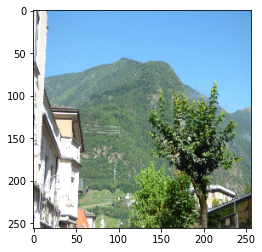

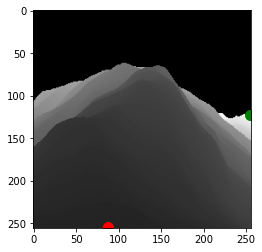

In [4]:
import matplotlib.pyplot as plt

for image, label in dataset.take(1):
    plt.imshow(image)
    plt.show()

    # Get the position of the largest and smallest values
    max_position = np.where(label == np.amax(label))
    min_position = np.where(label == np.amin(label[label > 100]))

    # Plot the image with a red dot on the position of the smallest value and a green dot on the position of the largest value
    plt.imshow(label, cmap='gray')
    plt.plot(max_position[1], max_position[0], 'go', markersize=10)
    plt.plot(min_position[1], min_position[0], 'ro', markersize=10)
    plt.show()

In [5]:
def unet_model(input_shape=(256, 256, 3)):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Down-sampling through the model
    skips = []
    for filters in [64, 128, 256]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("selu")(x)

        skips.append(x)
        x = layers.MaxPooling2D(2)(x)

    # Bottleneck
    x = layers.Conv2D(512, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Up-sampling through the model
    for filters, skip in reversed(list(zip([256, 128, 64], skips))):
        x = layers.UpSampling2D(2)(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("selu")(x)

    # Final layer
    outputs = layers.Conv2D(1, 1)(x)
    outputs = layers.Activation('selu')(outputs)

    return keras.Model(inputs=inputs, outputs=outputs)

In [6]:
#add extra dimension to the dataset
train_dataset = dataset.take(2500).map(lambda x,y: (tf.expand_dims(x,axis=0), tf.expand_dims(y,axis=0)))
val_dataset = dataset.skip(2500).take(100).map(lambda x,y: (tf.expand_dims(x,axis=0), tf.expand_dims(y,axis=0)))
test_dataset = dataset.skip(2600).take(500).map(lambda x,y: (tf.expand_dims(x,axis=0), tf.expand_dims(y,axis=0)))

In [7]:
# Create a UNET model
model = unet_model()

# Compile the model with loss and optimizer
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=tf.keras.metrics.MeanAbsoluteError())   #Check if mean or last shown value

# Define a callback to save the model after each epoch
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    "models/depth_model_5.h5", save_freq="epoch"
)

In [8]:
# Train the model on the dataset
model.fit(train_dataset, epochs=5, callbacks=[checkpoint_callback], validation_data=val_dataset, use_multiprocessing=True, workers=4, shuffle=True) 

Epoch 1/5
2500/2500 [==============================] - 254s 97ms/step - loss: -33948.2969 - mean_absolute_error: 2301.6963 - val_loss: -30399.1172 - val_mean_absolute_error: 1994.3738
Epoch 2/5
2500/2500 [==============================] - 241s 97ms/step - loss: -35092.5625 - mean_absolute_error: 2302.2158 - val_loss: -30399.1230 - val_mean_absolute_error: 1993.4536
Epoch 3/5
2500/2500 [==============================] - 242s 97ms/step - loss: -35092.6367 - mean_absolute_error: 2301.5142 - val_loss: -30399.1230 - val_mean_absolute_error: 1993.4457
Epoch 4/5
2500/2500 [==============================] - 240s 96ms/step - loss: -35092.6367 - mean_absolute_error: 2301.5142 - val_loss: -30399.1230 - val_mean_absolute_error: 1993.4436
Epoch 5/5
2500/2500 [==============================] - 240s 96ms/step - loss: -35092.6367 - mean_absolute_error: 2301.5120 - val_loss: -30399.1230 - val_mean_absolute_error: 1993.4430


In [9]:
#perform inference on the test dataset
model.evaluate(test_dataset, use_multiprocessing=True, workers=4)

500/500 [==============================] - 138s 53ms/step - loss: -29717.1309 - mean_absolute_error: 1948.8130


[-29717.130859375, 1948.81298828125]

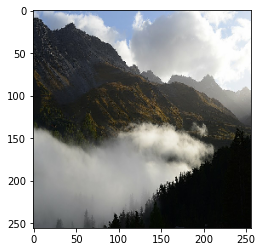

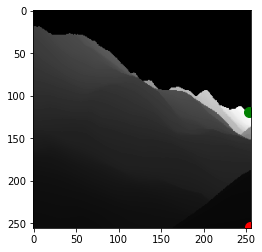

1/1 [==============================] - 0s 153ms/step


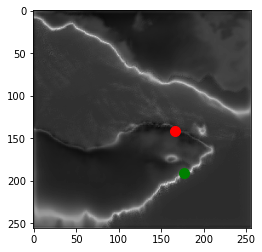

In [10]:
#show the output of the model with a random image from the test dataset
import matplotlib.pyplot as plt

for image, label in test_dataset.take(1):
    plt.imshow(image[0])
    plt.show()

    # Get the position of the largest and smallest values
    max_position = np.where(label[0] == np.amax(label[0]))
    min_position = np.where(label[0] == np.amin(label[0][label[0] > 100]))

    # Plot the image with a red dot on the position of the smallest value and a green dot on the position of the largest value
    plt.imshow(label[0], cmap='gray')
    plt.plot(max_position[1], max_position[0], 'go', markersize=10)
    plt.plot(min_position[1], min_position[0], 'ro', markersize=10)
    plt.show()

    # Perform inference with the model
    prediction = model.predict(image)[0]

    # Get the position of the largest and smallest values
    max_position = np.where(prediction == np.amax(prediction))
    min_position = np.where(prediction == np.amin(prediction[prediction > 0]))

    # Plot the image with a red dot on the position of the smallest value and a green dot on the position of the largest value
    plt.imshow(prediction, cmap='gray')
    plt.plot(max_position[1], max_position[0], 'go', markersize=10)
    plt.plot(min_position[1], min_position[0], 'ro', markersize=10)
    plt.show()

## Using DPT pretrained model with Baseline Sky Detection

In [1]:
from ipyfilechooser import FileChooser
fc = FileChooser('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset')

#choose image file
display(fc)

FileChooser(path='C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset', filename='', title='', show_hidden=False…

In [13]:
from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import time

image = Image.open(fc.selected)

processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

# prepare image for the model
inputs = processor(images=image, return_tensors="pt")

#start time
start = time.time()
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth
#end time
end = time.time()

print(end - start)

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3.925492763519287


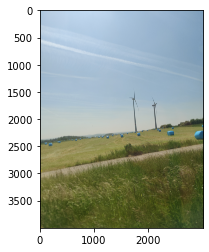

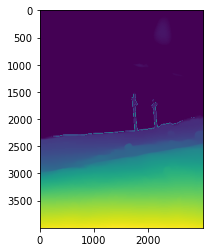

In [14]:
#show the image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()
plt.imshow(depth)
plt.show()

In [15]:
import numpy as np
from baseline import baseline_mean_shift_third

# assuming `image` is a PIL Image object, convert it to a numpy array
image = np.array(image)

# apply mean shift algorithm
mask, _, _ = baseline_mean_shift_third(image)

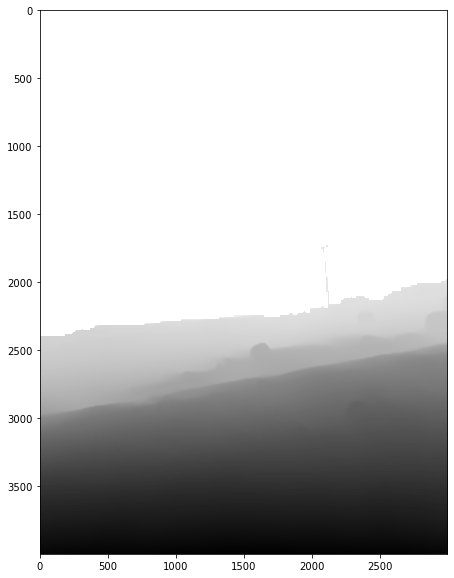

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#invert the values of depth
depth_inverted = np.invert(depth)

#convert depth_inverted to PIL Image object
depth_inverted = Image.fromarray(depth_inverted)

#assuming `mask` and `depth_inverted` are defined, use mask on the depth image
depth_masked = np.ma.masked_array(depth_inverted, mask=mask)

#show the masked depth image
plt.figure(figsize=(10, 10))
plt.imshow(depth_masked, cmap='gray')
plt.show()

In [63]:
from ipyfilechooser import FileChooser
model_path = FileChooser('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\masterthesis\\models')

#choose image file
display(model_path)

FileChooser(path='C:\Users\cjbla\OneDrive\Desktop\Code\masterthesis\models', filename='', title='', show_hidde…

In [66]:
#import the model using keras
from tensorflow import keras
model = keras.models.load_model(model_path.selected)

#show the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 303, 303, 32  864         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 303, 303, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

TypeError: Invalid shape (1, 19, 19, 39) for image data

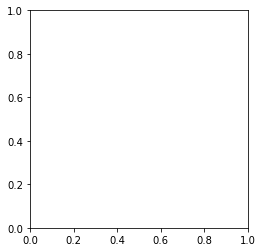

In [71]:
import tensorflow as tf
import cv2
import numpy as np

def preprocess_image(image_path, target_size):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # Resize the image to the target size (608, 608)
    image = cv2.resize(image, target_size)
    # Normalize the image pixel values to the range [0, 1]
    image = image / 255.0
    # Add a batch dimension to the image
    image = np.expand_dims(image, axis=0)
    return image

# Load the saved model
model = tf.keras.models.load_model(model_path.selected)

# Input layer details
input_shape = (None, 608, 608, 3)

# Input image path
image_path = fc.selected

# Preprocess the input image
input_image = preprocess_image(image_path, (608, 608))

# Get the first entry from the batch (assuming batch_size=1)
output_image = output[0]

# Convert pixel values to the range [0, 255]
output_image = (output_image * 255).astype(np.uint8)

# Display the output image (you need to have OpenCV installed)
plt.imshow(output_image)
plt.show()